# 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Bagging"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 배깅: 부트스트랩 샘플리을 통한 분류 앙상블

다양한 분류기를 만드는 한 가지 방법은 각기 다른 훈련 알고리즘을 사용하는 것이다. 또 다른 방법은 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것이다. 훈련 세트에서 중복을 허용하여 샘플링하는 방식을 <b>배깅</b><sup>bagging</sup>(bootstrap aggregating의 줄임말<sup><a id="a02" href="#p01">[1]</a></sup>)이라 하며, 중복을 허용하지 않고 샘플링하는 방식을 <b>페이스팅</b><sup>pasting</sup>이라고 한다.

다시 말해 배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있다. 하지만 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링할 수 있다. 교차 검증이 데이터 세트 간에 중첩을 허용하지 않는 것과 다르게 배깅 방식은 중첩을 허용한다. 따라서 10,000개의 데이터를 10개의 분류기가 배깅 방식으로 나누더라도 각 1,000개의 데이터 내에는 중복된 데이터가 있다. 이 샘플링과 훈련 과정을 [그림 1]에 타나냈다.

<b>그림 1</b> 배깅과 페이스팅은 훈련 세트에서 무작위로 샘플링하여 여러 개의 예측기를 훈련한다.
<div style="text-align:center;">
    <img src="./images/Bagging/bagging.png">
</div>

## 배깅 알고리즘의 작동 방식

배깅 분류기의 부트스트랩 샘플링의 작동 방식을 확실히 이해하기 위해 [그림 2]에 나오는 예를 생각해 보자. 다음에 (1에서 7까지 인덱스가 부여된) 일곱 개의 훈련 샘플이 있다. 배깅 단계마다 중복을 허용하여 랜덤하게 샘플링된다. 각각의 부트스트랩 샘플을 사용하여 분류기 $C_j$를 학습한다. 일반적으로 가지치기하지 않는 결정 트리를 분류기로 사용한다.

<b>그림 2</b> 배깅과 페이스팅은 훈련 세트에서 무작위로 샘플링하여 여러 개의 예측기를 훈련한다.
<div style="text-align:center;">
    <img src="./images/Bagging/bootstrap.png">
</div>

[그림 2]에서 볼 수 있듯이 각 분류기는 훈련 세트에서 추출한 랜덤한 부분 집합을 사용한다. 중복을 허용한 샘플링을 하기 때문에 각 부분 집합에는 일부가 중복되어 있고 원본 샘플 중 일부는 포함되어 있지 않다. 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다. 수집 함수는 전형적으로 분류일 때는 <b>통계적 최빈값</b><sup>statistical mode</sup>(즉, 직접 투표 분류기처럼 가장 많은 예측 결과)이고 회귀에 대해서는 평균을 계산한다. 개별 예측기는 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소한다. 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어든다.

[그림1]에서 볼 수 있듯이 예측기는 모두 동시에 다른 CPU 코어나 서버에서 병렬로 학습시킬 수 있다. 이와 유사하게 예측도 병렬로 수행할 수 있다. 이런 확장성 덕분에 배깅과 페이스팅의 인기가 높다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 1994년 레오 브레이만<sup>Leo Breiman</sup>이 기술 보고서에서 배깅을 처음 제안했다. 배깅으로 불안정한 모델의 정확도를 향상하고 과대적합의 정도를 감소시킬 수 있다는 것을 보였다. 배깅에 관해 더 자세히 알고 싶다면 온라인에 공개된 그의 리포트를 꼭 한 번 읽어 보자.<sup><a id="a02" href="#p02">[2]</a></sup>
</div>

## 사이킷런의 배깅과 페이스팅

사이킷런은 배깅과 페이스팅을 위해 간편한 API로 구현된 BaggingClassifier(회귀의 경우에는 BaggingRegressor)를 제공한다. 다음은 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드다.<sup><a id="a03" href="#p03">[3]</a></sup> 각 분류기는 훈련 세트에 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련된다(이는 배깅의 경우이고, 대신 페이스팅을 사용하려면 bootstrap=False로 지정하면 된다). n_jobs 매개변수는 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정한다(-1로 지정하면 가용한 모든 코어를 사용한다).

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=500 ,noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [3]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print("Bagging의 정확도: %.2f" % accuracy_score(y_test, y_pred))
print("Decision Tree의 정확도: %.2f" % accuracy_score(y_test, y_pred_tree))

Bagging의 정확도: 0.90
Decision Tree의 정확도: 0.86


<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> BaggingClassifier는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면(즉, predict_proba() 함수가 있으면) 직접 투표 대신 자동으로 간접 투표 방식을 사용한다.
</div>

다음 그림은 단일 결정 트리의 결정 경계와 500개의 트리를 사용한 배깅 앙상블(이전 코드로 만든 모델)의 결정 경계를 비교한 것이다. 둘 다 moons 데이터셋에 훈련시켰다. 여기서 볼 수 있듯이 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘된 것 같다. 앙상블은 비슷한 편향에서 더 작은 분산을 만든다(훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙하다).

In [4]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

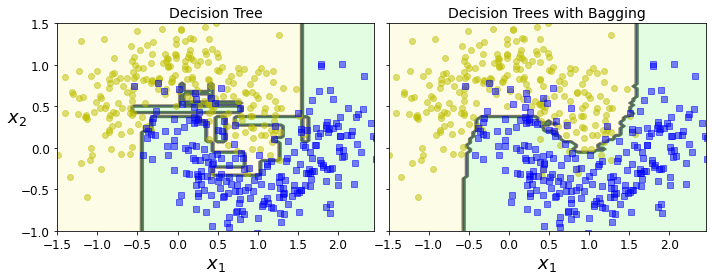

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

다음 그림은 15개 결정 트리의 결정 경계를 중첩한 것이다. 여기서 볼 수 있듯이 개별 결정 트리는 불완전하지만 앙상블되면 매우 좋은 결정 경계를 만든다

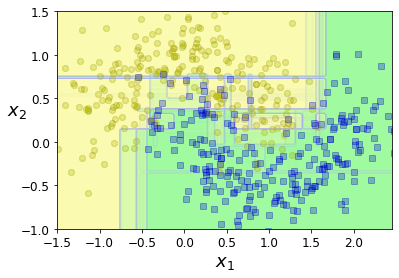

In [6]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)
    
plt.show()

실전에서 고차원 데이터셋을 사용하는 더 복잡한 분류 문제라면 단일 결정 트리가 쉽게 과대적합될 수 있다. 이런 경우에 배깅 알고리즘의 강력함이 제대로 발휘될 수 있다. 마지막으로 배깅 알고리즘은 모델의 분산을 감소하는 효과적인 방법이지만 모델의 편향을 낮추는 데는 효과적이지 않다. 즉, 모델이 너무 단순해서 데이터에 있는 경향을 잘 잡아내지 못한다. 이것이 배깅을 수행할 때 편향이 낮은 모델, 예를 들어 가지치기하지 않은 결정 트리를 분류기로 사용하여 앙상블을 만드는 이유다.

부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높다. 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킨다. 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호한다. 그러나 시간과 CPU 파워에 여유가 있다면 교차 검증으로 배깅과 페이스팅을 모두 평가해서 더 나은 쪽을 선택하는 것이 좋다.

## oob 평가

배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있다. BaggingClassifier는 기본값으로 중복을 허용하여(bootstrap=True) 훈련 세트의 크기만큼만인 n개 샘플을 선택한다. 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미한다. 선택되지 않은 훈련 샘플의 나머지 37%를 oob<sup>out-of-bag</sup> 샘플이라고 부른다. 예측기마다 남겨진 37%는 모두 다르다.

예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있다. 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻는다.

사이킷런에서 BaggingClassifier를 만들 때 oob_score=True로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행한다. 다음 코드는 이 과정을 보여준다. 평가 점수 결과는 oob_score_ 변수에 저장되어 있다.

In [7]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

oob 평가 결과를 보면 이 BaggingClassifier는 테스트 세트에서 약 89.9%의 정확도를 얻을 것으로 보인다. 확인해보자.

In [8]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

테스트 세트에서 91.2%의 정확도를 얻었다. 얼추 비슷하다.

oob 샘플에 대한 결정 함수의 값도 oob_decision_function_ 변수에서 확인할 수 있다. 이 경우 결정 함수는 각 훈련 샘플의 클래스 확률을 반환한다(기반이 되는 예측기가 <code>predict_proba()</code> 메서드를 갖고 있기 때문에). 다음 예를 보면 oob 평가는 첫 번째 훈련 샘플이 양성 클래스에 속할 확률을 67.72%로 추정하고 있다(그리고 음성 클래스에 속할 확률은 32.28%다).

In [9]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

## 랜덤 패치와 랜덤 서브스페이스

BaggingClassifier는 특성 샘플링도 지원한다. 샘플링은 max_features, bootstrap_features 두 매개변수로 조절된다. 작동 방식은 max_samples, bootstrap과 동일하지만 샘플이 아니고 특성에 대한 샘플링이다. 따라서 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련된다.

이 기법은 특히 (이미지와 같은) 매우 고차원의 데이터셋을 다룰 때 유용하다. 훈련 특성과 샘플을 모두 샘플링하는 것을 <b>랜덤 패치 방식</b><sup>random patches method</sup>이라고 한다. 훈련 샘플을 모두 사용하고(bootstrap=False이고 max_samples=1.0로 설정) 특성은 샘플링하는 (bootstrap_features=True 그리고/또는 max_features는 1.0보다 작게 설정) 것을 <b>랜덤 서브스페이스 방식</b><sup>random subspaces method</sup>이라고 한다.

특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춘다.

# 랜덤 포레스트

배깅은 앞에서 소개한 보팅과는 다르게, 같은 알고리즘으로 여러 개의 분류기를 만들어서 보팅으로 최종 결정하는 알고리즘이다. 배깅의 대표적인 알고리즘은 랜덤 포레스트다. 랜덤 포레스트는 다재 다능한 알고리즘이다. 앙상블 알고리즘 중 비교적 빠른 수행 속도를 가지고 있으며, 다양한 영역에서 높은 예측 성능을 보이고 있다. 랜덤 포레스트의 기반 알고리즘은 결정 트리로서, 결정 트리의 쉽고 직관적인 장점을 그대로 가지고 있다(랜덤 포레스트뿐만 아니라 부스팅 기반의 다양한 앙상블 알고리즘 역시 대부분 결정 트리 알고리즘을 기반 알고리즘으로 채택하고 있다).

랜덤 포레스트는 여러 개의 결정 트리 분류기가 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링해 개별적으로 학습을 수행한 뒤 최종적으로 모든 분류기가 보팅을 통해 예측 결정을 하게 된다.

<b>그림 3</b> 랜덤 포레스트
<div style="text-align:center;">
    <img src="./images/Bagging/RF.png">
</div>

원본 데이터의 건수가 10개인 학습 데이터 세트에 랜덤 포레스트를 3개의 결정 트리 기반으로 학습하려고 n_estimators=3으로 하이퍼 파라미터를 부여하면 다음과 같이 데이터 서브세트가 만들어진다.

<b>그림 3</b> 부트스트래핑 샘플링 방식
<div style="text-align:center;">
    <img src="./images/Bagging/bs_sampling.png">
</div>

앞서 언급했듯이 랜덤 포레스트는 일반적으로 배깅 방법 (또는 페이스팅)을 적용한 결정 트리의 앙상블이다. 전형적으로 max_samples를 훈련 세트의 크기로 지정한다. BaggingClassifier에 DecisionTreeClassifier를 넣어 만드는 대신 결정 트리에 최적화되어 사용하기 편리한 RandomForestClassifier를 사용할 수 있다(비슷하게 회귀 문제를 위한 RandomForestRegressor가 있다).<sup><a id="a05" href="#p05">[5]</a></sup> 다음은 (최대 16개의 리프 노드를 갖는) 500개 트리로 이뤄진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드다.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf)
print("랜덤 포레스트 정확도: {0:.4f}".format(accuracy))

랜덤 포레스트 정확도: 0.9120


RandomForestClassifier는 몇 가지 예외가 있지만 (트리 성장의 조절을 위한) DecisionTree Classifier의 매개변수와 앙상블 자체를 제어하는 데 필요한 BaggingClassifier의 매개변수를 모두 가지고 있다.<sup><a id="a06" href="#p06">[6]</a></sup>

랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입한다. 이는 결국 트리를 더욱 다양하게 만들고 (다시 한번) 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어낸다. 다음은 BaggingClassifier를 사용해 앞의 RandomForestClassifier와 거의 유사하게 만든 것이다.

In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

RandomForestClassifier의 예측과 BaggingClassifier의 예측이 거의 동일한 것을 확인할 수 있다.

In [12]:
np.sum(y_pred == y_pred_rf) / len(y_pred)

1.0

## Generalization Error

각각의 개별트리는 과대적합 될 수 있다. 랜덤 포레스트는 tree 수가 충분히 많을 때 큰 수의 법칙에 의해 과대적합되지 않고 그 에러는 limiting value에 수렴한다.

$$
\mathrm{Generalization\,\,error} \leq \frac{\bar{\rho}(1-s^2)}{s^2} \to \text{Upper bound of Generalization error}\\
\bar{\rho}: \text{Decision Tree 사이의 평균 상관관계}\\
s: \text{올바로 예측한 tree와 잘못 예측한 tree 수 차이의 평균}
$$

<ul>
    <li>개별 트리의 정확도가 높을수록 s 증가</li>
    <li>Bagging과 random subspace 기법은 각 모델들의 독립성, 일반화, 무작위성을 최대화시켜 모델간의 상관관계 $\bar{\rho}$를 감소시킴</li>
    <li>개별 트리의 정확도, 독립성이 높을수록 랜덤 포레스트의 성능이 높아짐</li>
</ul>

## 랜덤 포레스트 하이퍼 파라미터 및 튜닝

트리 기반의 앙상블 알고리즘의 단점을 굳이 뽑자면 하이퍼 파라미터가 너무 많고, 그로 인해서 튜닝을 위한 시간이 많이 소모된다는 것이다. 더구나 많은 시간을 소모했음에도 튜닝 후 예측 성능이 크게 향상되는 경우가 많지 않아서 더욱 아쉽다. 트리 기반 자체의 하이퍼 파라미터가 원래 많은 데다 배깅, 부스팅, 학습, 정규화 등을 위한 하이퍼 파라미터까지 추가되므로 일반적으로 다른 ML 알고리즘에 비해 많을 수밖에 없다. 그나마 랜덤 포레스트가 적은 편에 속하는데, 결정 트리에서 사용되는 하이퍼 파라미터와 같은 파라미터가 대부분이기 때문이다.

<ul>
    <li><b>n_estimators:</b> 랜덤 포레스트에서 결정 트리의 개수를 지정한다. 디폴트는 100개다. 많이 설정할수록 좋은 성능을 기대할 수 있지만 계속 증가시킨다고 성능이 무조건 향상되는 것은 아니다. 또한 늘릴수록 학습 수행 시간이 오래 걸리는 것도 감안해야 한다.</li>
    <li>max_features는 결정 트리에 상요된 max_features 파라미터와 같다. 하지만 RandomForestClassifier의 기본 max_features는 'None'이 아니라 'auto', 즉 'sqrt'와 같다. 따라서 랜덤 포레스트의 트리를 분할하는 피처를 참조할 때 전체 피처가 아니라 sqrt(전체 피처 개수)만큼 참조한다(전체 피처가 16개라면 분할을 위해 4개 참조).</li>
    <li>max_depth나 min_samples_leaf와 같이 결정 트리에서 과대적합을 개선하기 위해 사용되는 파라미터가 랜덤 포레스트에도 똑같이 적용될 수 있다.</li>
</ul>

## 엑스트라 트리

랜덤 포레스트에서 트리를 만들 때 (앞서 이야기한 것처럼) 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용한다. 트리를 더욱 무작위하게 만들기 위해 (보통의 결정 트리처럼) 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택한다.

이와 같이 극단적으로 무작위한 트리의 랜덤 포레스트를 <b>익스트림 랜덤 트리</b><sup>extremely randomized trees</sup> 앙상블(또는 줄여서 <b>엑스트라 트리</b><sup>extra-trees</sup>)이라고 부른다. 여기서도 역시 편향이 늘어나지만 대신 분산을 낮추게 된다. 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠르다.

엑스트라 트리를 만들려면 사이킷런의 ExtraTreesClassifier를 사용한다. 사용법은 RandomForestClassifier와 같다. 마찬가지로 ExtratTreesRegressor도 RandomForestRegressor와 같은 API를 제공한다.<sup><a id="a07" href="#p07">[7]</a></sup>

<b>TIP</b> RandomForestClassifier가 ExtraTreeClassifier보다 더 나을지 혹은 더 나쁠지 예단하긴 어렵다. 일반적으로 둘 다 시도해보고 교차 검증으로 비교해보는 것이 유일한 방법이다(그리고 그리드 탐색으로 하이퍼파라미터 튜닝을 한다).

## 특성 중요도

랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것이다.<sup><a id="a08" href="#p08">[8]</a></sup> 사이킷런은 어떤 특성을 사용한 노드가 (랜덤 포레스트에 있는 모든 트리에 걸쳐서) 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정한다. 더 정확히 말하면 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같다.<sup><a id="a09" href="#p09">[9]</a></sup>

사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화한다. 이 값은 feature_importances_ 변수에 저장되어 있다. 예를 들어 다음 코드는 iris 데이터셋에 RandomForestClassifier를 훈련시키고 각 특성의 중요도를 출력한다. 가장 중요한 특성은 꽃잎의 길이(44%)와 너비(42%)이고 꽃받침의 길이와 너비는 비교적 덜 중요해 보인다(각각 11%와 2%).

In [13]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


이와 유사하게 MNIST 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 각 픽셀의 중요도를 그래프로 나타내면 다음과 같은 이미지를 얻게 된다.

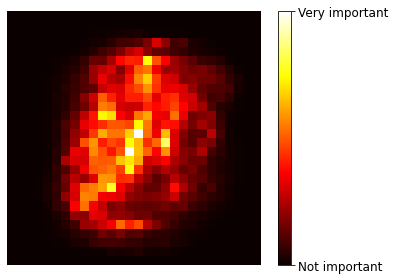

In [14]:
from sklearn.datasets import fetch_openml

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

랜덤 포레스트는 특히 특성을 선택해야 할 때 어떤 특성이 중요한지 빠르게 확인할 수 있어 매우 편리하다.

# 미주

<b id="p01">1</b> 통계학에서는 중복을 허용한 리샘플링<sup>resampling</sup>을 <b>부트스트래핑</b><sup>bootstrapping</sup>이라고 한다. [↩](#a01)

<b id="p02">2</b> <a href="https://link.springer.com/content/pdf/10.1007/BF00058655.pdf" target='blank'>Bagging predictors, L. Breiman, Machine Learning, 24(2): 123-140, 1996</a> [↩](#a02)

<b id="p03">3</b> max_samples 매개변수는 0.0 ~ 1.0 사이의 실수로 지정할 수도 있다. 이렇게 지정하면 샘플리오디는 데이터 수는 훈련 세트의 크기에 max_samples를 곱한 값이 된다. [↩](#a03)

<b id="p04">4</b> n이 커지면 이 비율이 $1 - \mathrm{exp}(-1)\approx63.212$%에 가까워진다. n개의 샘플에서 무작위로 하나를 추출할 때 선택되지 않을 확률은 $1 - \frac{1}{n}$이고 이를 n번 반복했을 때도 선택되지 않을 확률은 $(1-\frac{1}{n})^n$이다. 여기에 로그를 취하고 로피탈의 정리를 적용하면 이 값이 $e^{-1}$과 같아진다. 따라서 샘플링될 확률은 $1-e^{-1} = 0.63212$가 된다. [↩](#a04)

<b id="p05">5</b> BaggingClassifier는 결정 트리 이외의 모델을 앙상블하고 싶을 때 여전히 유용하다. [↩](#a05)

<b id="p06">6</b> 몇 가지 예외 항목은 splitter(무조건 "best"), presort(무조건 False), max_samples(무조건 1.0), base_estimator(무조건 지정된 매개변수를 사용한 DecisionTreeClassifier)이다. spliiter와 presort는 DecisionTreeClassifier의 매개변수이고, max_samples와 base_estimator는 BaggingClassifier의 매개변수다. [↩](#a06)

<b id="p07">7</b> 엑스트라 트리의 분할을 단일 결정 트리에 적용한 모델은 ExtraTreeClassifier와 ExtraTreeRegressor이다. [↩](#a07)

<b id="p08">8</b> 결정 트리를 기반으로 하는 모델은 모두 특성 중요도를 제공한다. DecisionTreeClassifier의 특성 중요도는 일부 특성을 완전히 배제시키지만, 무작위성이 주입된 RandomForestClassifier는 거의 모든 특성에 대해 평가할 기회를 가진다. [↩](#a08)

<b id="p09">9</b> 결정 트리의 특성 중요도는 노드에 사용된 특성별로 (현재 노드의 샘플 비율 x 불순도) - (왼쪽 자식 노드의 샘플 비율 x 불순도) - (오른쪽 자식 노드의 샘플 비율 x 불순도)와 같이 계산하여 더하고, 특성 중요도의 합이 1이 되도록 전체 합으로 나누어 정규화한다. 여기서 샘플 비율은 트리 전체 샘플 수에 대한 비율이다. 랜덤 포레스트의 특성 중요도는 각 결정 트리의 특성 중요도를 모두 계산하여 더한 후 트리 수로 나눈 것이다. [↩](#a09)